## Test the energy conservation between pupil and focal plane
With astropy.unit to get the right units <3
We import pupil, field, detector and propagator to test the energy conservation between entrance pupil and detector.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from fiatlux.field import Field
from fiatlux.source import Source
from fiatlux.pupil import Pupil
from fiatlux.detector import Detector
from fiatlux.propagator import Propagator

import astropy.units as u
import astropy.constants as C

field_size = 256
telescope_diameter = 1
source = Source(magnitude=7)

field = Field(source=source, field_size=field_size, verbose=True)
print(field)

pupil = Pupil(
    field_size=field_size,
    aperture_shape="circular",
    aperture_size=telescope_diameter,
)
print(pupil)

camera = Detector(
    field_size=field_size,
    display_intensity=False,
    exposure_time=.15,
    noise=True,
    quantum_efficiency=0.67,
    readout_noise_variance=2,
    dark_current=2,
    bitdepth=16,
)
print(camera)

<field>
  * field_size : 256.0 pix
  * scale : None
  * wavelength : 5.5e-07 m
<pupil>
  * field_size : 256 (px)
  * scale : 64.0 pix / m (px/m)
  * aperture_size : 1.0 m (m)
<detector>
  * field_size : 256
  * camera_name : Default camera
  * readout_noise_variance : 2.0 electron
  * dark_current : 2.0 electron / s
  * offset : 100.0 adu
  * bitdepth : 16
  * sensitivity : 5.0 adu / electron


We decide to make a unitary pupil, i.e. $\sum_x \sum_y \left| I(x,y) \right|^2 dx dy = 1$ so that at the end, when the light goes on the detector, and in order to get the number of photon on each pixel, we only got to multiply the pixels' values by $N_\gamma = \frac{S}{hc}\int_\lambda \lambda f_\lambda T_\lambda d\lambda$ the number of photon collected by the pupil ($S$ is the collecting surface, $f_\lambda$ if the spectral irradiance in $[\text{W}\text{m}^{-2} \text{nm}^{-1}]$ and $T_\lambda$ the transmission of the filter.

The integral of the whole field after the pupil must then be equal to $1$.

In [6]:

print(
    f"Energy of the whole field before pupil : {np.sum(np.abs(field.complex_amplitude)**2)} (equal to {field.field_size}² = {field.field_size**2})\n"
)

# Going through the pupil
field * pupil

print(
    f"Integrated flux calculated after pupil on the field's complex amplitude {np.sum(np.abs(field.complex_amplitude)**2)}"
)

Energy of the whole field before pupil : 65536.0 (equal to 256.0 pix² = 65536.0 pix2)

Going through pupil
Integrated flux calculated after pupil on the field's complex amplitude 0.9999999999999999


After the pupil, if the field is not obstructed or dimmed, the energy remains unitary.

In [7]:
# Propagation to the camera
field > camera

print(
    f"Integrated flux @ camera computed on the field : {np.sum(np.abs(field.complex_amplitude)**2)}"
)

print(
    f"Integrated flux @ camera computed on the camera : {np.sum(np.abs(camera.complex_amplitude)**2)}"
)

Propagate field from pupil to focal plan
Propagating following propagator
Arriving on detector
Integrated flux @ camera computed on the field : 1.0000000000000002
Integrated flux @ camera computed on the camera : 1.0000000000000002


Now the hardest part is to come... Integrate the source flux (time and wavelength) and produce the number of photons reaching each pixel.

The Source class is created to carry information of the field and the spectral distribution of the source.

[[  0.     0.     0.   ...   0.     0.     0.  ]
 [  0.    16.75  44.89 ...  46.23  42.88  15.41]
 [  0.    55.61 115.91 ... 153.43 127.3   46.23]
 ...
 [  0.    71.02 168.84 ... 199.66 184.92  56.95]
 [  0.    37.52 119.26 ... 153.43 121.27  45.56]
 [  0.    12.73  54.94 ...  62.98  44.89  12.06]] electron 2.3 electron
adu adu


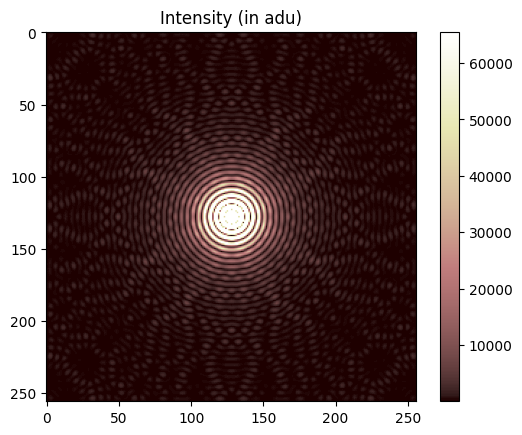

In [8]:
camera.disp_intensity()